# Browning trends XGBoost model - local run with loop

### Peter R.
#### 2025-03-27

Here we use BFAST trends derived from 5-year periods of forest EVI (enhanced vegetation index) time series (ts) observations. These trends were produced using a BFAST01 *h* parameter equal to 0.05 (or ~ 5% of the ts) and BFAST Classify (p < 0.05). Trends were modelled using Extreme Gradient Boosting (XGBoost) regression. The response variable is forest EVI trend slope and predictors are forest and climate-related variables. The code below is for positive breaks only.  

The data used here were produced with R and DuckDb. Climate variables were created using ClimateNA. A bigger set of climate variables were shortlisted using variation inflation factor (VIF). The code for putting the data frame together is not shown here.

We decided to test XGB models (boosted regression trees, BRT) with subsets of data. The following XGB models and dataframe subsets are run:

- Dataframe3 (df0): All records

- Dataframe6 (df3): Disturbed records only

- Dataframe9 (df6): Undisturbed records only

This notebook has three main parts. The first one runs XGBoost with different subsets of the data. The second part does the same but removes records matched with disturbance data. The last part, runs the best model and creates figures.

Some points to have in mind:

- Some of the XGBoost parameter values used below were obtained by using RandomizedSearchCV available in Scikit-learn. This step  is not shown here.

- Given that Canlad data (Guideon *et al.* 2017) had the most matches (spatiotemporal overlap) with trend data we used this data source to filter out matched trends. This was done so that variation by forest and climate-related predictors can be better tunned in.

- I should try to further optimize the XGB parameters

- I would like to run a classify XGB (outcomes: G, B, abd N) to see what factors are associted with 'no change detected' (N) pixels.


### Setup

In [1]:
# Peter R.
# XGBoost script

#Here I am using a loop to run several models at a time

import os
import time

import pandas as pd
from numpy import nan
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# for feature importance plots
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np

#for dependency plots
from sklearn.inspection import PartialDependenceDisplay

#start = time.time()

# Get the current working directory
cwd = os.getcwd()

#print(cwd)

# DRAC directory
#os.chdir("/home/georod/projects/def-mfortin/georod/scripts/github/forc_trends/models/xgboost")
# Win directory
os.chdir(r'C:\Users\Peter R\github\forc_stpa\models\xgboost\exploratory')


print("XGB version:", xgb.__version__)
print("positive trends")


# Windows
df1 = pd.read_csv(r'.\data\df2_trends_p1_vars_browning_v6.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v2.csv', skipinitialspace=True)
#df1.head()


df11 = pd.get_dummies(df1, columns=['for_pro'], dtype=float)
df11 = pd.get_dummies(df11, columns=['gfc'], dtype=float)
df11 = pd.get_dummies(df11, columns=['canlad'], dtype=float)
df11 = pd.get_dummies(df11, columns=['insc'], dtype=float)
df11 = pd.get_dummies(df11, columns=['abio'], dtype=float)



XGB version: 1.7.6
positive trends


In [2]:
# Notes
# - Here I am reorganizing the columns so that all dfs have the outcome as the first column
#Df0: all rows (including nulls)
df0 = df11.loc[(df11['for_age_2003'] >= 0) & (df11['elev'] > 0)]

# Df3:
#df3 = df11.dropna()
#df3 = df11.loc[(df11['gfc_0'] = 0) & (df11['canlad_0']  = 0) & (df11['insc_0']  = 0) & (df11['abio_0']  = 0)] # undisturbed pix
#df3.describe()

#dfall = [df0, df3, df6, df9, df23]
#dfall = [df0, df3] # df0 & df3 are the same df so far
dfall = [df0]


#Df0: all rows
#dfall = [df11]


In [3]:
print(dfall[0].describe())  # 11018

                 pix     year  for_age_2003  for_con_2003          elev  \
count   10127.000000  10127.0  10127.000000  10127.000000  10127.000000   
mean   237167.221191   2003.0     90.859603     34.461823    375.535490   
std    138216.246576      0.0     15.503036     19.293782     85.656141   
min       613.000000   2003.0     40.004000      2.675000    121.629000   
25%    124192.500000   2003.0     79.762500     18.704000    307.491000   
50%    224723.000000   2003.0     88.362000     29.259000    388.362000   
75%    356393.000000   2003.0    100.386000     48.282000    446.374000   
max    493323.000000   2003.0    170.139000     88.409000    543.641000   

       p1_trend  p1_trend_slope  trend_20yrs  delta_for_age_lag3  \
count   10127.0    10127.000000  6483.000000                 0.0   
mean        2.0       -4.937435     1.550979                 NaN   
std         0.0        1.789729     1.448057                 NaN   
min         2.0      -19.674000     1.000000        

In [4]:
(dfall[0]).head()
#range(len(dfall))

,pix,year,for_age_2003,for_con_2003,elev,p1_trend,p1_trend_slope,trend_20yrs,delta_for_age_lag3,delta_for_con_lag3,...,for_pro_0,for_pro_1,gfc_0,gfc_1,canlad_0,canlad_1,insc_0,insc_1,abio_0,abio_1
0,144618,2003,81.875,50.776,427.887,2,-4.893,NaN,NaN,NaN,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,144619,2003,86.364,50.896,433.170,2,-3.325,NaN,NaN,NaN,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,144724,2003,86.723,75.129,393.268,2,-4.691,NaN,NaN,NaN,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,144756,2003,67.549,73.425,333.204,2,-4.121,NaN,NaN,NaN,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,144804,2003,87.107,56.466,323.329,2,-2.954,NaN,NaN,NaN,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [5]:
#df0.loc[:,['pix', 'canlad_0']].head()

In [8]:
# Count NAs per columns. These NAs are correct as nan. the rad variables above had -9999 values which could have biased the results.
# Hence, the rad vars were dropped.
df0.isna().sum()

pix             0
year            0
for_age_2003    0
for_con_2003    0
elev            0
               ..
canlad_1        0
insc_0          0
insc_1          0
abio_0          0
abio_1          0
Length: 113, dtype: int64

In [9]:
# create a new df with all the VIF vars and then remove outliers
#colVIF = ['for_age_2003','for_con_2003', 'delta_for_age','delta_for_con', 'delta_cmi_sm_lag1','delta_cmi_sm_lag2', 'p1_trend_slope','delta_cmi_sm_lag3', 'delta_cmi_sm', 'delta_dd5_wt_lag1', 'delta_dd5_wt_lag2', 'delta_dd5_wt_lag3', 'delta_dd5_wt', 'for_pro_0', 'gfc',
# 'canlad', 'harv', 'avg_for_con', 'cmi_sm_cqv', 'max_cmi_sm_rel30', 'max_cmi_sm_rel30_reg']


#df0[colVIF].describe()
#df2 = df0[colVIF]

In [10]:
# Remove outliers from VIF vars
# https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe
#import pandas as pd
#import numpy as np
#from scipy import stats

#df3 = df2[(np.abs(stats.zscore(df2)) < 3).all(axis=1)] # all vars
#df3.describe()
#df3 = df2

In [11]:
#dfall = [df0, df3]

In [12]:
#print(dfall[1].describe()) 

###  1. Models with all records

In [6]:
# loop version

# Base model
cols1 = ['delta_cmi_sm_lag3',  'delta_dd5_wt_lag3',  'delta_cmi_sm_lag2',  'delta_dd5_wt_lag2',  'delta_cmi_sm_lag1',  
         'delta_dd5_wt_lag1',  'delta_for_age',  'delta_for_con',  'delta_cmi_sm',  'delta_dd5_wt',  'deltap_for_age',  
         'deltap_for_con',  'cmi_sm_rel30_reg',  'dd5_wt_rel30_reg',  'cmi_sm_rel30p_reg',  'dd5_wt_rel30p_reg',  
         'cmi_sm_rel30',  'dd5_wt_rel30']

# VIF columns + protected
cols2 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
         'for_pro_0']

# VIF columns + protected + disturbance1
cols3 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
         'for_pro_0', 'gfc_0' ]

# VIF columns + protected + disturbance2
cols4 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
         'for_pro_0', 'canlad_0']

# VIF columns + protected + disturbance3
cols5 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
         'for_pro_0', 'insc_0']

# VIF columns + protected + disturbance4
cols6 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
         'for_pro_0', 'abio_0']

# VIF columns + protected + disturbance x 2
cols7 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
         'for_pro_0', 'insc_0' ,'abio_0' ]

# Custom/manual 
cols8 = ['deltap_dd5_wt_lag1', 'deltap_cmi_sm_lag1', 'deltap_for_age', 'deltap_for_con', 'cmi_sm_rel30', 'cmi_sm_rel30p_reg',
         'dd5_wt_rel30', 'dd5_wt_rel30p_reg',
         'for_pro_0', 'insc_0' ,'abio_0']


#df_labs = ['df0','df3', 'df6', 'df9', 'df23']
#model_labs = ['First variable set', 'VIF variable set', 'VIFplus variable set']
df_labs = ['df0', 'df3']
#model_labs = ['First variable set', 'VIF variable set', 'VIFplus variable set']
model_labs = ['Base model', 'VIF+pro', 'VIF+pro+dist1', 'VIF+pro+dist2', 'VIF+pro+dist3', 'VIF+pro+dist4', 
              'VIF+pro+distx2','VIF+manual']
#df_labs = ['df0', 'df3']
#model_labs = ['First variable set', 'VIFplus variable set']


# Index 6 has the slope for period 1 after recoding for_pro

for z in range(len(dfall)):
    list_of_vars = [[cols1], [cols2], [cols3], [cols4], [cols5], [cols6], [cols7], [cols8]]
    #list_of_vars = [[cols1]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            #print(x)
            X1 = dfall[z][x]
            #print(X1.describe())
            y1 = dfall[z].iloc[:,6].abs()
            seed = 7 # random seed to help with replication
            testsize1 = 0.33 # percent of records to test after training
            x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
            model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=50,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.15, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=8, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=1000, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
               # EVALUATION (with test)
            eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
                #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
            model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
                # make predictions for test data
            y_pred = model_bp2.predict(x1_test)
            predictions = [round(value) for value in y_pred]
                # retrieve performance metrics
            results = model_bp2.evals_result()
            mse = mean_squared_error(y1_test, y_pred)
                #r2 = explained_variance_score(y1_test, ypred)
            r2 = r2_score(y1_test, y_pred)
                # adjusted R-squared
            adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))

            #print("MSE: %.2f" % mse)
            var1 = "%.2f" % mse

            #print("RMSE: %.2f" % (mse**(1/2.0)))
            var2 = "%.2f" % (mse**(1/2.0))

            #print("R-sq: %.3f" % r2)
            var3 = "%.3f" % r2

            #print("R-sq-adj: %.3f" % adj_r2)
            var4 = "%.3f" % adj_r2

            var5 = X1.shape[0]
            var6 = X1.shape[1]

            # row for table
            print("|", (z+1), "|", df_labs[z], "|", model_labs[index], "|", var1, "|", var2, "|", var3, "|", var4, "|",var5, "|",var6, "|")
            
        

| 1 | df0 | Base model | 1.63 | 1.28 | 0.540 | 0.537 | 10127 | 18 |
| 1 | df0 | VIF+pro | 1.84 | 1.36 | 0.481 | 0.480 | 10127 | 7 |
| 1 | df0 | VIF+pro+dist1 | 1.69 | 1.30 | 0.522 | 0.521 | 10127 | 8 |
| 1 | df0 | VIF+pro+dist2 | 1.68 | 1.30 | 0.525 | 0.524 | 10127 | 8 |
| 1 | df0 | VIF+pro+dist3 | 1.84 | 1.36 | 0.481 | 0.480 | 10127 | 8 |
| 1 | df0 | VIF+pro+dist4 | 1.83 | 1.35 | 0.484 | 0.483 | 10127 | 8 |
| 1 | df0 | VIF+pro+distx2 | 1.81 | 1.35 | 0.488 | 0.487 | 10127 | 9 |
| 1 | df0 | VIF+manual | 1.85 | 1.36 | 0.478 | 0.476 | 10127 | 11 |


**Table 1**: Model comparison for greening trends. Standard data set with all records.


|ID|Data frame| Model   | MSE| RMSE| R-sq | R-sq-adj |N rows| N vars|
| --------| --------| --------| --------| -------- | ------- |-------- | ------- |------- |
| 1 | df0 | Base model | 1.75 | 1.32 | 0.483 | 0.480 | 10127 | 18 |
| 2 | df0 | VIF+pro | 1.96 | 1.40 | 0.421 | 0.419 | 10127 | 7 |
| 3 | df0 | VIF+pro+dist1 | 1.71 | 1.31 | 0.495 | 0.493 | 10127 | 8 |
| 4 | df0 | VIF+pro+dist2 | 1.81 | 1.34 | 0.465 | 0.464 | 10127 | 8 |
| 5 | df0 | VIF+pro+dist3 | 1.95 | 1.40 | 0.422 | 0.421 | 10127 | 8 |
| 6 | df0 | VIF+pro+dist4 | 1.88 | 1.37 | 0.444 | 0.443 | 10127 | 8 |
| 7 | df0 | VIF+pro+distx2 | 1.90 | 1.38 | 0.437 | 0.436 | 10127 | 9 |
| 8 | df0 | VIF+manual | 1.96 | 1.40 | 0.420 | 0.418 | 10127 | 11 |









In [ ]:
# first run
#| 1 | df0 | First variable set | 0.82 | 0.90 | 0.209 | 0.206 | 11018 | 14 |
#| 1 | df0 | VIF variable set | 0.90 | 0.95 | 0.132 | 0.131 | 11018 | 6 |
#| 1 | df0 | VIFplus variable set | 0.86 | 0.93 | 0.169 | 0.167 | 11018 | 9 |

# second run
#| 1 | df0 | First variable set | 0.81 | 0.90 | 0.195 | 0.192 | 11018 | 14 |
#| 1 | df0 | VIF variable set | 0.87 | 0.93 | 0.141 | 0.140 | 11018 | 6 |
#| 1 | df0 | VIFplus variable set | 0.87 | 0.93 | 0.139 | 0.136 | 11018 | 9 |
#| 1 | df0 | VIFplus2 | 0.92 | 0.96 | 0.087 | 0.085 | 11018 | 8 |


In [14]:
#print(delta_)
for z in range(len(dfall)):
    list_of_vars = [[cols1]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            print(dfall[z].iloc[:,6].abs())
            print(dfall[z][x])
    
    
#['delta_dd5_wt_lag3', 'delta_cmi_sm_lag2', 'delta_cmi_sm_lag1']
    

0         4.749
1         4.382
2         3.481
3         5.735
4         3.681
          ...  
10388    13.706
10389     4.599
10390     4.800
10391     4.916
10392     7.351
Name: p1_trend_slope, Length: 10127, dtype: float64
       delta_cmi_sm_lag3  delta_dd5_wt_lag3  delta_cmi_sm_lag2  \
0                 -8.731              0.000              4.161   
1                 -9.618              0.000              3.083   
2                 -8.010             -1.000              5.337   
3                 -9.151              0.000              3.469   
4                 -9.138              0.000              3.463   
...                  ...                ...                ...   
10388            -11.844             -0.013              6.497   
10389            -11.932             -0.052              3.648   
10390             -9.391             -1.000              6.887   
10391             -7.331              0.000              6.611   
10392             -5.681              0.000   

###  2. Models without records that have disturbance matches

When dealing with negative forest EVI breaks, those records matched with disturbance data can be considered explained. This is, we know what caused the negative breaks. You would expect that most negative breaks would have a match in space-time with disturbance data (remote sensing derived). However, there were a significant amount of negative breaks that could not be matched. Perhaps some of these unmatched breaks could have overlapped with other disturbanced data that we did not have (i.e., windthrows). Below negative breaks that matched with Hansen et al.'s (2013) disturbance data were removed and XGBoost models with climate and forest-related data were run.

In [139]:
# How many records are matched to disturbance data?
#print(df2[['hansen_year']].describe()) # N=2775
#print(df2[['magnitude', 'fire_year', 'harv_year', 'canlad_year', 'hansen_year']].describe()) # Hansen=? with df4; Hansen=648 with df5

In [15]:
# Df3: disturbed pix
#df3 = df11.dropna()
df3 = df11.loc[(df11['for_age_2003'] >= 0) & (df11['elev'] > 0) & (df11['canlad_0'] == 0)] 
#df3.describe()

# Df6: undisturbed pix
df6 = df11.loc[(df11['for_age_2003'] >= 0) & (df11['elev'] > 0) & (df11['canlad_0'] == 1) ] 

#dfall = [df0, df3, df6, df9, df23]
dfall2 = [df3, df6]


In [19]:
dfall2[0].shape
#1528+8599

(1528, 113)

In [20]:
df3.isna().sum()
#df6.isna().sum()

pix             0
year            0
for_age_2003    0
for_con_2003    0
elev            0
               ..
canlad_1        0
insc_0          0
insc_1          0
abio_0          0
abio_1          0
Length: 113, dtype: int64

In [21]:
# loop version

# loop version

# Here I remove all disturbance variables as they are not needed in a split data set


# Base model
cols1 = ['delta_cmi_sm_lag3',  'delta_dd5_wt_lag3',  'delta_cmi_sm_lag2',  'delta_dd5_wt_lag2',  'delta_cmi_sm_lag1',  
         'delta_dd5_wt_lag1',  'delta_for_age',  'delta_for_con',  'delta_cmi_sm',  'delta_dd5_wt',  'deltap_for_age',  
         'deltap_for_con',  'cmi_sm_rel30_reg',  'dd5_wt_rel30_reg',  'cmi_sm_rel30p_reg',  'dd5_wt_rel30p_reg',  
         'cmi_sm_rel30', 'dd5_wt_rel30']

# VIF columns + protected
cols2 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
         'for_pro_0']

# VIF columns + protected + disturbance1
#cols3 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
#         'for_pro_0', 'gfc_0' ]

# VIF columns + protected + disturbance2
#cols4 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
#         'for_pro_0', 'canlad_0']

# VIF columns + protected + disturbance3
#cols5 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
#         'for_pro_0', 'insc_0']

# VIF columns + protected + disturbance4
#cols6 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
#         'for_pro_0', 'abio_0']

# VIF columns + protected + disturbance x 2
#cols7 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
#         'for_pro_0', 'insc_0' ,'abio_0' ]

# Custom/manual 
#cols8 = ['deltap_dd5_wt_lag1', 'deltap_cmi_sm_lag1', 'deltap_for_age', 'deltap_for_con', 'cmi_sm_rel30', 'cmi_sm_rel30p_reg',
#         'dd5_wt_rel30', 'dd5_wt_rel30p_reg',
#         'for_pro_0', 'insc_0' ,'abio_0']
cols8 = ['deltap_dd5_wt_lag1', 'deltap_cmi_sm_lag1', 'deltap_for_age', 'deltap_for_con', 'cmi_sm_rel30', 'cmi_sm_rel30p_reg',
         'dd5_wt_rel30', 'dd5_wt_rel30p_reg',
         'for_pro_0']


#df_labs = ['df0','df3', 'df6', 'df9', 'df23']
#model_labs = ['First variable set', 'VIF variable set', 'VIFplus variable set']
df_labs = ['df3', 'df6']
#model_labs = ['First variable set', 'VIF variable set', 'VIFplus variable set']
model_labs = ['Base model', 'VIF+pro', 'VIF+manual']
#df_labs = ['df0', 'df3']
#model_labs = ['First variable set', 'VIFplus variable set']


# Index 6 has the slope for period 1 after recoding for_pro

for z in range(len(dfall2)):
    list_of_vars = [[cols1], [cols2], [cols8]]
    #list_of_vars = [[cols1]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            #print(x)
            X1 = dfall2[z][x]
            #print(X1.describe())
            y1 = dfall2[z].iloc[:,6].abs()
            seed = 7 # random seed to help with replication
            testsize1 = 0.33 # percent of records to test after training
            x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
            model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=50,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.15, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=8, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=1000, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
               # EVALUATION (with test)
            eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
                #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
            model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
                # make predictions for test data
            y_pred = model_bp2.predict(x1_test)
            predictions = [round(value) for value in y_pred]
                # retrieve performance metrics
            results = model_bp2.evals_result()
            mse = mean_squared_error(y1_test, y_pred)
                #r2 = explained_variance_score(y1_test, ypred)
            r2 = r2_score(y1_test, y_pred)
                # adjusted R-squared
            adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))

            #print("MSE: %.2f" % mse)
            var1 = "%.2f" % mse

            #print("RMSE: %.2f" % (mse**(1/2.0)))
            var2 = "%.2f" % (mse**(1/2.0))

            #print("R-sq: %.3f" % r2)
            var3 = "%.3f" % r2

            #print("R-sq-adj: %.3f" % adj_r2)
            var4 = "%.3f" % adj_r2

            var5 = X1.shape[0]
            var6 = X1.shape[1]

            # row for table
            print("|", (z+1), "|", df_labs[z], "|", model_labs[index], "|", var1, "|", var2, "|", var3, "|", var4, "|",var5, "|",var6, "|")
            
        

| 1 | df3 | Base model | 4.82 | 2.20 | 0.484 | 0.465 | 1528 | 18 |
| 1 | df3 | VIF+pro | 5.21 | 2.28 | 0.443 | 0.435 | 1528 | 7 |
| 1 | df3 | VIF+manual | 6.01 | 2.45 | 0.357 | 0.346 | 1528 | 9 |
| 2 | df6 | Base model | 1.03 | 1.01 | 0.268 | 0.264 | 8599 | 18 |
| 2 | df6 | VIF+pro | 1.08 | 1.04 | 0.229 | 0.227 | 8599 | 7 |
| 2 | df6 | VIF+manual | 1.12 | 1.06 | 0.204 | 0.202 | 8599 | 9 |


**Table 2**: Model comparison for browning trends. Data frame was split in two. One subset included only records with disturbed pixels (ID 1 to 3). The second subset included records that were not disturbed (ID 4 to 6). Disturbance fields removed from predictor set.

|ID| Data frame| Model   | MSE| RMSE| R-sq | R-sq-adj | N rows| N vars|
| --------| --------| -------- | ------- |-------- | ------- |------- |------- |------- |
| 1 | df3 | Base model | 4.82 | 2.20 | 0.484 | 0.465 | 1528 | 18 |
| 2 | df3 | VIF+pro | 5.21 | 2.28 | 0.443 | 0.435 | 1528 | 7 |
| 3 | df3 | VIF+manual | 6.01 | 2.45 | 0.357 | 0.346 | 1528 | 9 |
| 4 | df6 | Base model | 1.03 | 1.01 | 0.268 | 0.264 | 8599 | 18 |
| 5 | df6 | VIF+pro | 1.08 | 1.04 | 0.229 | 0.227 | 8599 | 7 |
| 6 | df6 | VIF+manual | 1.12 | 1.06 | 0.204 | 0.202 | 8599 | 9 |






In [13]:
# check one more
# df2.shape
df3.shape

(409, 113)

In [33]:
#print(dfall[0].describe())

### 3. Best Model

The best model for positive breaks was ID=5 in Table 1 (df3, VIF variable set). A close second was ID=6 in Table 1 (df3, VIFplus variable set) without removed disturbance record matches. Given that I want to keep some conistency among the XGBoost models for positive and negative breaks. I will choose ID=6 (Table 1) as the best model. This way both negative and positive breaks have the same set of variables. Note that the best model only has 116 records, that is only about 1% of the original data frame.

Below are the corresponding plots for this model.

In [21]:
# This df3 is the non-distubance filtered version (Table 1 above). So, we need to re-create the df.
#df3 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.1315068) & (df11['magnitude'] < -500)] #N= 116
#dfall2 = [df3]
#dfall2 = [df0]

In [22]:
# creat new df
#dfall2 = [df0]
# check once more
# df2.shape
dfall[0].shape

(10127, 113)

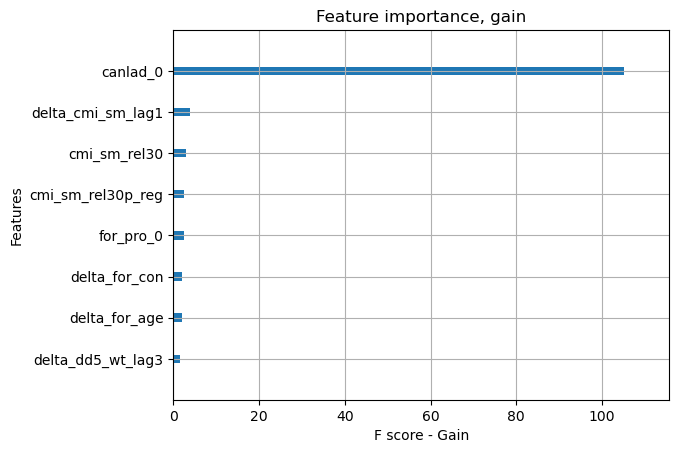

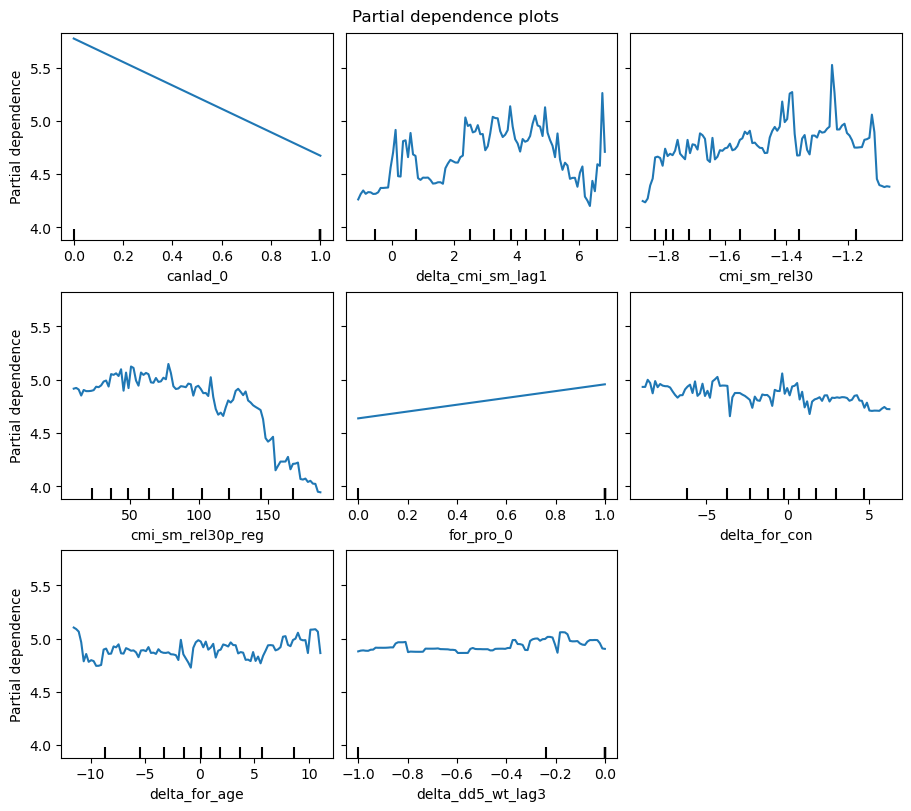

In [31]:
# loop version
#cols3 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3', 'for_age', 'for_pro_0']

#cols2 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag2', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con','for_pro_0']


for z in range(len(dfall)):
    list_of_vars = [[cols4]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            #print(x)
            X1 = dfall[z][x]
            #print(X1.describe())
            y1 = dfall[z].iloc[:,6].abs()
            seed = 7 # random seed to help with replication
            testsize1 = 0.33 # percent of records to test after training
            x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
            model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=50,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.15, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=8, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=1000, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
               # EVALUATION (with test)
            eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
                #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
            model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
                # make predictions for test data
            y_pred = model_bp2.predict(x1_test)
            predictions = [round(value) for value in y_pred]
                # retrieve performance metrics
            results = model_bp2.evals_result()
            mse = mean_squared_error(y1_test, y_pred)
                #r2 = explained_variance_score(y1_test, ypred)
            r2 = r2_score(y1_test, y_pred)
                # adjusted R-squared
            adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))           
            
            # Feature importance plot
            xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                        xlabel='F score - Gain', ylabel='Features', 
                        importance_type='gain', max_num_features=15, grid=True, show_values=False) #, values_format='{v:.2f}' )

            pyplot.savefig(r'.\figs\version1\neg_gain_m{y}_v10.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
            #pyplot.show()
            
            # create lis of feature names to be used in dependency plot so that high ranking vars are plotted
            features_names1 = pd.DataFrame()
            features_names1['columns'] = X1.columns
            features_names1['importances'] = model_bp2.feature_importances_
            features_names1.sort_values(by='importances',ascending=False,inplace=True)
            features_names2 = features_names1['columns'].tolist()[0:10]

            # Partial dependence plots
            _, ax1 = plt.subplots(figsize=(9, 8), constrained_layout=True)

            display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

            _ = display.figure_.suptitle(("Partial dependence plots"), fontsize=12, )

            pyplot.savefig(r'.\figs\version1\neg_partial_dep_m{y}_v10.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')

            pyplot.show()


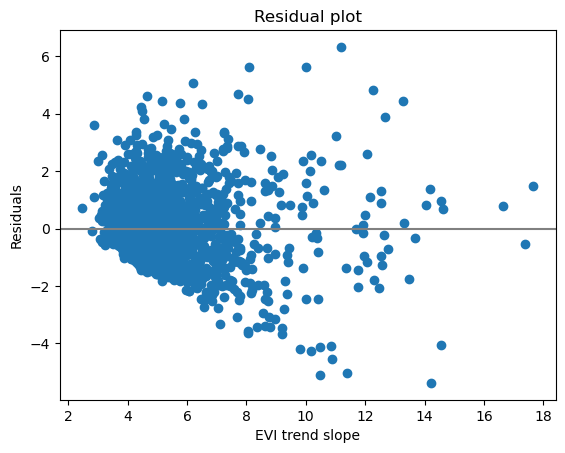

In [32]:
# Model prediction residuals

residuals = y1_test-y_pred

mean = residuals.mean()
std = residuals.std()

std_residuals = (residuals - mean)/std


pyplot.scatter(y_pred, std_residuals)

pyplot.ylabel('Residuals')
pyplot.xlabel("EVI trend slope")
pyplot.title('Residual plot')
pyplot.axhline(0, color="gray")

pyplot.show()

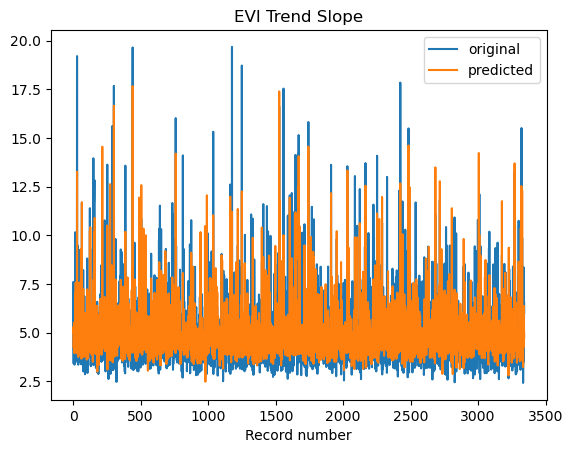

In [33]:
#import matplotlib.pyplot as plt

x_ax = range(len(y1_test))
pyplot.plot(x_ax, y1_test, label="original")
pyplot.plot(x_ax, y_pred, label="predicted")

pyplot.xlabel("Record number") # Order of observations/records in vector

pyplot.title("EVI Trend Slope")

pyplot.legend()

pyplot.savefig(r'.\figs\version1\neg_predicted_m{y}_v10.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')

pyplot.show()

In [66]:
# Plot tree. Use rankdir='LR' to make the plot show sideways
import graphviz

#fig, ax = pyplot.subplots(figsize=(8, 6)) #plt.figure(2, figsize=(8, 6))

format = 'png' #You should try the 'svg'

image = xgb.to_graphviz(model_bp2, num_trees = model_bp2.best_iteration) # best_iteration only works with early_stop_rounds

#Set a different dpi (works only if format == 'png')
image.graph_attr = {'dpi':'300'}

#image.render(r'.\figs\pos_decision_tree6.png', format = format)
image.render(r'.\figs\version5\neg_decision_tree_m{y}_v1.png'.format(y=len(x)), format = format)

#-#image

'figs\\version5\\neg_decision_tree_m9_v1.png.png'

In [46]:
# creat new df
#dfall2 = [df0]
# check once more
# df2.shape
#dfall2[0].shape
#dfall2[0].shape
#409+10609
#dfall2s1 = dfall2[0]
#dfall2s1[0].shape
dfall3 = [df3]
dfall3[0].shape

(1528, 113)

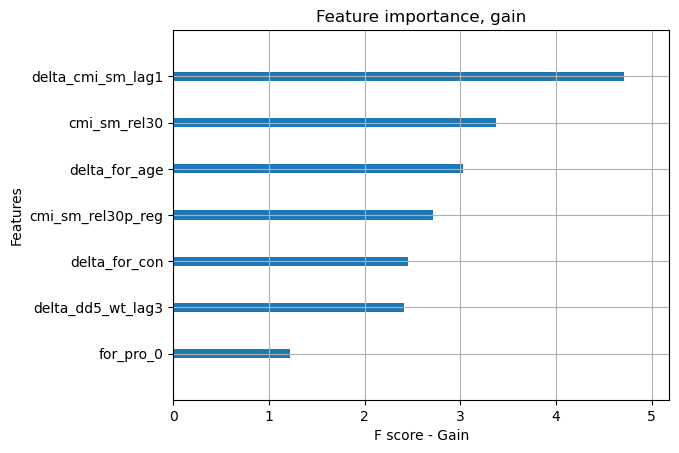

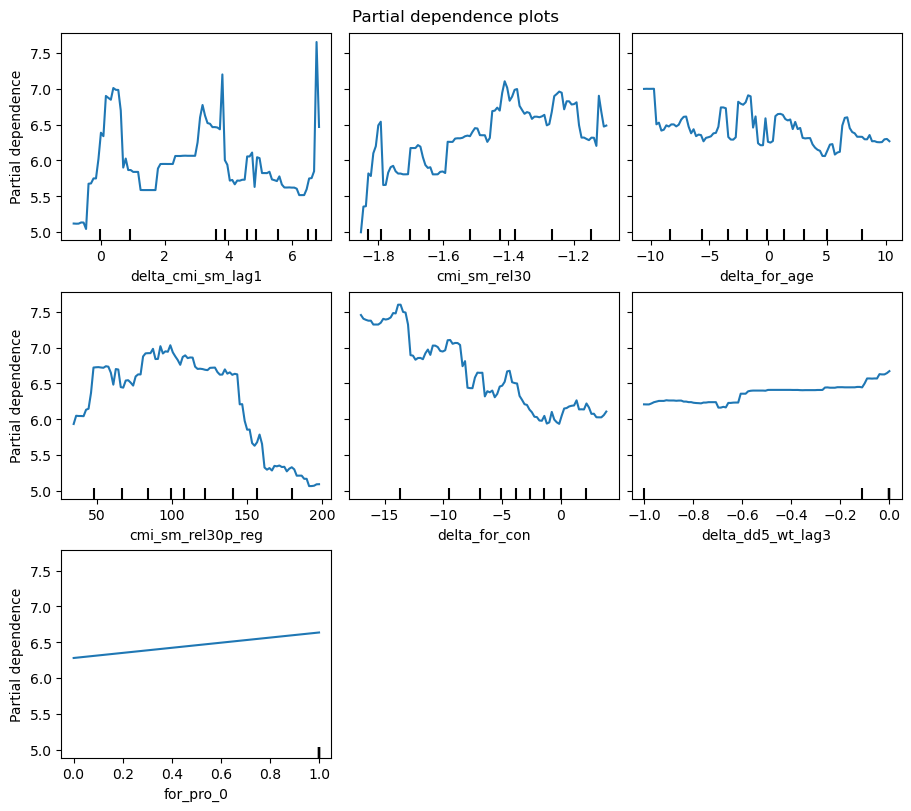

In [48]:
# Relative metric for split data, best where dist_0=1 (yes disturbance)
# loop version
#cols3 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3', 'for_age', 'for_pro_0']

#cols2 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag2', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con','for_pro_0']


for z in range(len(dfall3)):
    list_of_vars = [[cols2]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            #print(x)
            X1 = dfall3[z][x]
            #print(X1.describe())
            y1 = dfall3[z].iloc[:,6].abs()
            seed = 7 # random seed to help with replication
            testsize1 = 0.33 # percent of records to test after training
            x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
            model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=50,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.15, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=8, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=1000, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
               # EVALUATION (with test)
            eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
                #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
            model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
                # make predictions for test data
            y_pred = model_bp2.predict(x1_test)
            predictions = [round(value) for value in y_pred]
                # retrieve performance metrics
            results = model_bp2.evals_result()
            mse = mean_squared_error(y1_test, y_pred)
                #r2 = explained_variance_score(y1_test, ypred)
            r2 = r2_score(y1_test, y_pred)
                # adjusted R-squared
            adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))           
            
            # Feature importance plot
            xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                        xlabel='F score - Gain', ylabel='Features', 
                        importance_type='gain', max_num_features=15, grid=True, show_values=False) #, values_format='{v:.2f}' )

            pyplot.savefig(r'.\figs\version1\neg_gain_m{y}_v10_dist.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
            #pyplot.show()
            
            # create lis of feature names to be used in dependency plot so that high ranking vars are plotted
            features_names1 = pd.DataFrame()
            features_names1['columns'] = X1.columns
            features_names1['importances'] = model_bp2.feature_importances_
            features_names1.sort_values(by='importances',ascending=False,inplace=True)
            features_names2 = features_names1['columns'].tolist()[0:10]

            # Partial dependence plots
            _, ax1 = plt.subplots(figsize=(9, 8), constrained_layout=True)

            display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

            _ = display.figure_.suptitle(("Partial dependence plots"), fontsize=12, )

            pyplot.savefig(r'.\figs\version1\neg_partial_dep_m{y}_v10_dist.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')

            pyplot.show()


In [42]:
#print(dfall3[0]['p1_trend_slope_rel'].describe()) # 11018

In [49]:
dfall3 = [df6]
dfall3[0].shape

(8599, 113)

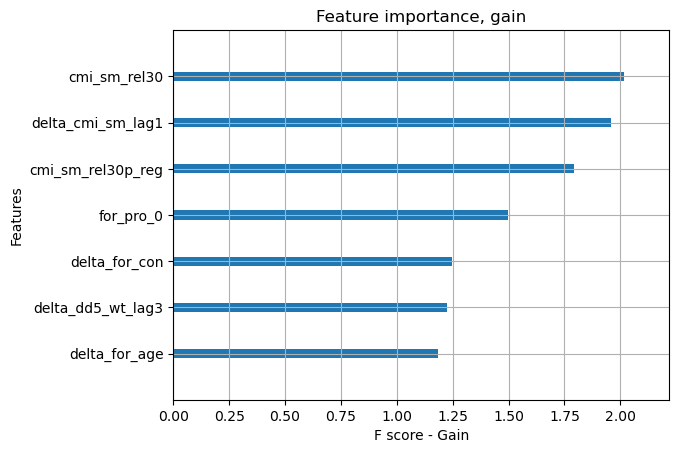

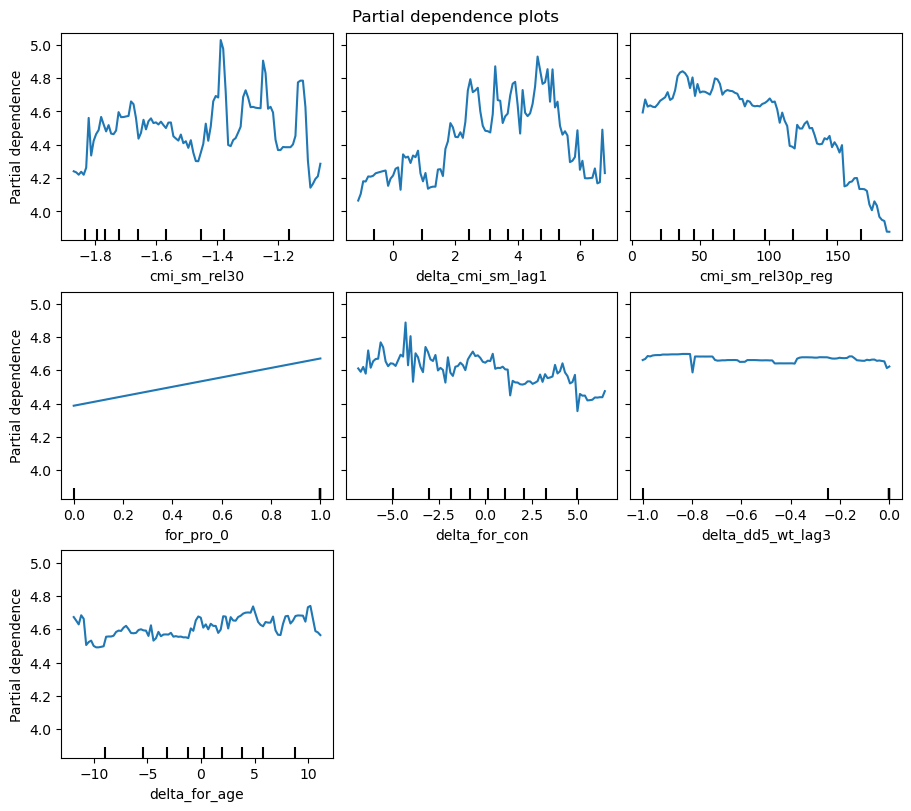

In [50]:
# Relative metric for split data, best where dist_0=0 (no disturbance)
# loop version
#cols3 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3', 'for_age', 'for_pro_0']

#cols2 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag2', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con','for_pro_0']


for z in range(len(dfall3)):
    list_of_vars = [[cols2]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            #print(x)
            X1 = dfall3[z][x]
            #print(X1.describe())
            y1 = dfall3[z].iloc[:,6].abs()
            seed = 7 # random seed to help with replication
            testsize1 = 0.33 # percent of records to test after training
            x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
            model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=50,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.15, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=8, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=1000, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
               # EVALUATION (with test)
            eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
                #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
            model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
                # make predictions for test data
            y_pred = model_bp2.predict(x1_test)
            predictions = [round(value) for value in y_pred]
                # retrieve performance metrics
            results = model_bp2.evals_result()
            mse = mean_squared_error(y1_test, y_pred)
                #r2 = explained_variance_score(y1_test, ypred)
            r2 = r2_score(y1_test, y_pred)
                # adjusted R-squared
            adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))           
            
            # Feature importance plot
            xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                        xlabel='F score - Gain', ylabel='Features', 
                        importance_type='gain', max_num_features=15, grid=True, show_values=False) #, values_format='{v:.2f}' )

            pyplot.savefig(r'.\figs\version1\neg_gain_m{y}_v10_undist.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
            #pyplot.show()
            
            # create lis of feature names to be used in dependency plot so that high ranking vars are plotted
            features_names1 = pd.DataFrame()
            features_names1['columns'] = X1.columns
            features_names1['importances'] = model_bp2.feature_importances_
            features_names1.sort_values(by='importances',ascending=False,inplace=True)
            features_names2 = features_names1['columns'].tolist()[0:10]

            # Partial dependence plots
            _, ax1 = plt.subplots(figsize=(9, 8), constrained_layout=True)

            display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

            _ = display.figure_.suptitle(("Partial dependence plots"), fontsize=12, )

            pyplot.savefig(r'.\figs\version1\neg_partial_dep_m{y}_v10_undist.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')

            pyplot.show()
